# FRF_Currituck Sound Station 01: Vertical Diffuse Attenuation Coefficient for Downwelling Photosynthetic Radiance EDA


python netcdf4 documentation: http://unidata.github.io/netcdf4-python

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import netCDF4
import time
import datetime

import sklearn.metrics
from sklearn.linear_model import LinearRegression

%matplotlib inline

### Read csv files for station 01, load into a dataframe, and wrangle...

In [2]:
data_path='/Users/paulp/GoogleDrive/projects/CurrituckSnd/CS_Stations/'

CS01_Kd=pd.read_csv(data_path+'CS01/FRF_CS01_Kd.csv').drop(['dt'], axis=1)

## Set date time values to Python datetime types, and round to nearest 1 second, on UT coordinated...
CS01_Kd['datetime'] = pd.to_datetime(CS01_Kd['datetime'], utc=True).dt.round('1s')

## Assign datetime field to data frame index
CS01_Kd.set_index('datetime', inplace=True)

## Aggregate sensor record indices in each of the three dataframes to the full day
CS01_Kd=CS01_Kd.resample('D').mean().copy()

CS01_Kd.head()

,PAR_Kd
datetime,
2016-05-02 00:00:00+00:00,1.473084
2016-05-03 00:00:00+00:00,1.299341
2016-05-04 00:00:00+00:00,1.319778
2016-05-05 00:00:00+00:00,3.497925
2016-05-06 00:00:00+00:00,1.568354


### Some initial 'looks' at the Kd data:

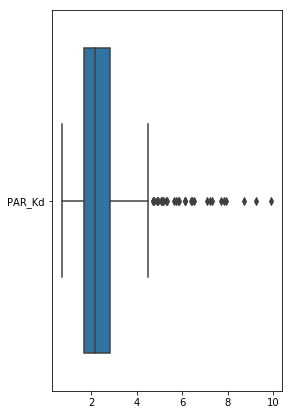

In [3]:
fig0=plt.figure(figsize=(14, 7))

sns.boxplot(data=CS01_Kd, orient='h', ax=fig0.add_subplot(1,3,1))

In [48]:
CS01_WC.describe()

,currentSpeed
count,687.000000
mean,0.100759
std,0.046565
min,0.024258
25%,0.068753
50%,0.091831
75%,0.122991
max,0.450826


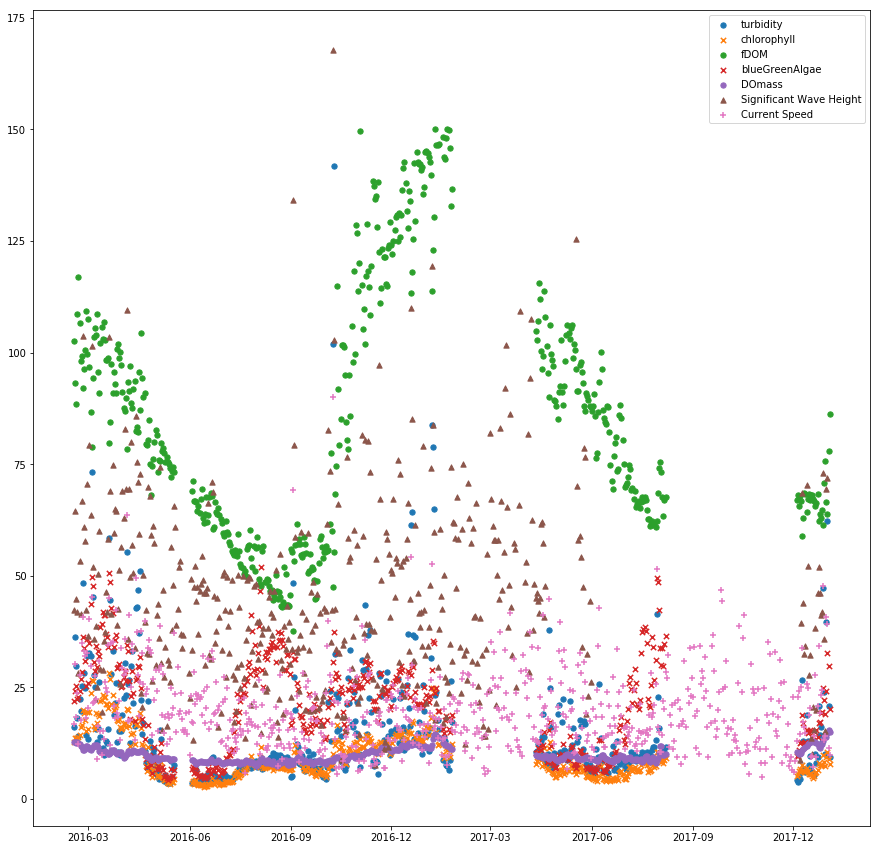

In [42]:
plt.subplots(figsize=(15,15))
    
plt.scatter(CS01_WQ.index, CS01_WQ['turbidity'], s=28, marker='o', label='turbidity')
plt.scatter(CS01_WQ.index, CS01_WQ['chlorophyll'], s=28, marker='x', label='chlorophyll')
plt.scatter(CS01_WQ.index, CS01_WQ['fDOM'], s=28, marker='o', label='fDOM')
plt.scatter(CS01_WQ.index, CS01_WQ['blueGreenAlgae'], s=28, marker='x', label='blueGreenAlgae')
plt.scatter(CS01_WQ.index, CS01_WQ['DOmass'], s=28, marker='o', label='DOmass')
plt.scatter(CS01_WV.index, CS01_WV['waveHs']*200, s=28, marker='^', label='Significant Wave Height')
plt.scatter(CS01_WC.index, CS01_WC['currentSpeed']*200, s=28, marker='+', label='Current Speed')
plt.legend()

#### The diffusion coefficient (Kd) 

If $K_d$ is computed as (Lambert-Beer):  $K_d={1 \over{z2-z1}} \ln({E_d(z_1) \over{E_d(z_2)} })$

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


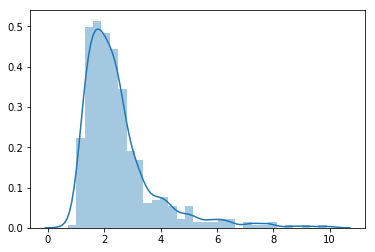

In [7]:
sns.distplot(CS01_Kd.dropna() )

### Load the Water Quality, Waves, and Currents data for Stations 01:

In [3]:
### Data loads...
## for Water Quality:
CS01_WQ=pd.read_csv(data_path+'CS01/FRF_CS01-EXO_ALL.csv', na_values=-999.990).drop(['gaugeDepth'], axis=1)

## for Surface Waves:
CS01_WV=pd.read_csv(data_path+'CS01/FRF_CS01-SBE26_Waves_ALL.csv', na_values=-999.990).drop(['depth','wavePeakFrequency'], axis=1)

## for Uni-directional Currents:
CS01_WC=pd.read_csv(data_path+'CS01/FRF_CS01-ADOP_Currents_ALL.csv', na_values=-999.990).drop(['aveE','aveN','currentDirection','meanPressure'], axis=1)

### Now for the wrangle part...
## set datetime fields to datatime objects and round to whole second
CS01_WQ['datetime'] = pd.to_datetime(CS01_WQ['datetime'], utc=True).dt.round('1s')
CS01_WV['datetime'] = pd.to_datetime(CS01_WV['datetime'], utc=True).dt.round('1s')
CS01_WC['datetime'] = pd.to_datetime(CS01_WC['datetime'], utc=True).dt.round('1s')


## Assign datetime field to data frame index
CS01_WQ.set_index('datetime', inplace=True)
CS01_WV.set_index('datetime', inplace=True)
CS01_WC.set_index('datetime', inplace=True)

## Aggregate sensor record indices in each of the three dataframes to the full day
CS01_WQ=CS01_WQ.resample('D').mean().copy()
CS01_WV=CS01_WV.resample('D').mean().copy()
CS01_WC=CS01_WC.resample('D').mean().copy()

### From earlier work we determined that an extraneous and unusually large turbidity value at Station 1 
### was an outlier and should be removed, so...
CS01_WQ=CS01_WQ[ CS01_WQ['turbidity'] < 200 ]

### Boxplot to check distribution, for outliers ,etc:

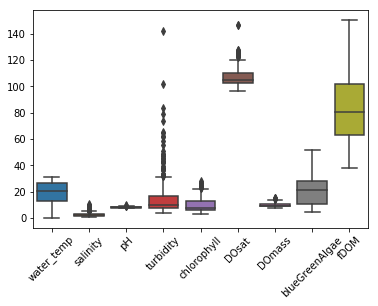

In [9]:
sns.boxplot(data=CS01_WQ)
plt.tick_params(axis='x', rotation=45)

### Station Summary:

In [10]:
CS01_WQ.describe()

,water_temp,salinity,pH,turbidity,chlorophyll,DOsat,DOmass,blueGreenAlgae,fDOM
count,476.000000,476.000000,287.000000,476.000000,476.000000,476.000000,476.000000,476.000000,476.000000
mean,19.587210,2.559371,8.182356,14.723885,9.422746,106.782628,9.838875,20.616158,85.149616
std,7.999004,1.762219,0.457524,13.716603,5.010857,6.481231,1.534351,10.529230,27.770566
min,-0.033494,0.375290,7.470679,3.380199,2.817421,96.086368,7.319305,4.214573,37.745360
25%,12.621320,1.414457,7.845332,7.155306,5.839448,102.196382,8.663700,10.559299,62.869050
50%,20.674010,2.105765,8.030018,10.092091,7.593175,105.000279,9.396618,20.981292,80.192415
75%,26.591644,3.038574,8.442825,16.823671,12.522818,110.032062,10.867926,28.320906,101.974673
max,31.217008,10.411459,9.415008,141.877011,28.249754,146.754551,15.459686,51.943703,150.153574


### The Relationship between Chl-a and blue-green algae

Bayley et al., 2003 indicate that Chl-a is a suitable proxy for phytoplankton abundance. Let's see what this relationship might look like for Currituck Sound

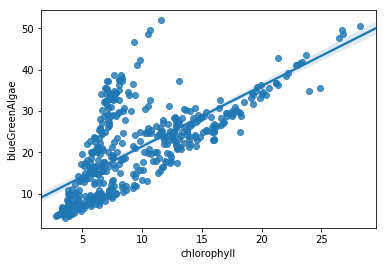

In [11]:
sns.regplot(x='chlorophyll', y='blueGreenAlgae', data=CS01_WQ)

### Salinity at Station 01:

2.55937053875237

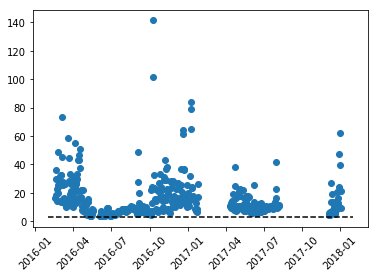

In [63]:
plt.scatter(CS01_WQ.index, CS01_WQ['turbidity'])
plt.tick_params(axis='x', rotation=45)
plt.hlines(CS01_WQ['salinity'].mean(), '2016-02-01', '2018-01-31', linestyle='--')
CS01['salinity'].mean()

In [4]:
graphics_path='/Users/paulp/GoogleDrive/projects/CurrituckSnd/plot_graphics/'

### Downwelling Diffuse Radiation Attenuation Coefficient - $K_d$ - _Linear_ Correlation Matrix

All station data included (less upper and lower PAR metrics)  

Annotations in matrix are Pearson Product Moment (r) statistics:

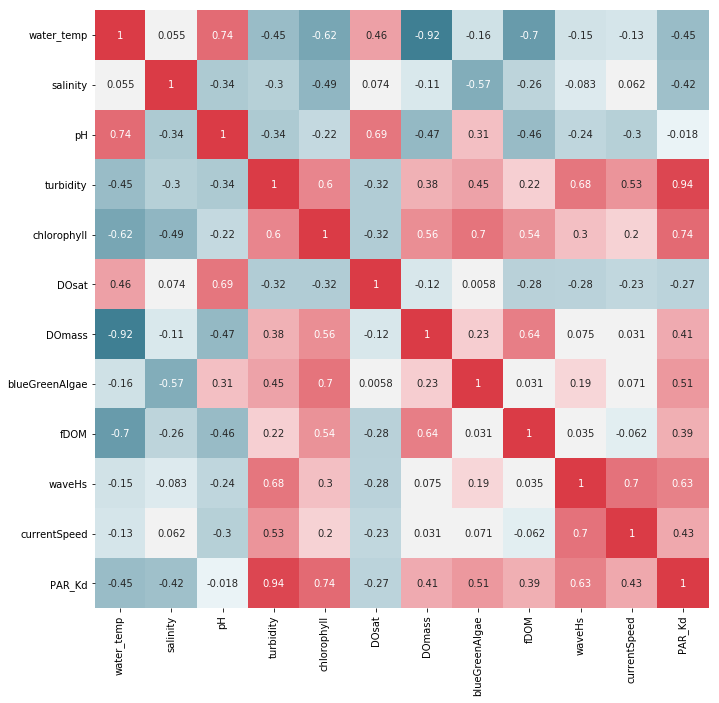

In [7]:
plt.subplots(figsize=(11,11) )
cmap = sns.diverging_palette(220, 10, center='light', as_cmap=True)
sns.heatmap( pd.concat([CS01_WQ, CS01_WV, CS01_WC, CS01_Kd],axis=1).corr(), cbar=False, annot=True, cmap=cmap )
plt.savefig(graphics_path+'Station01_Corr_Matrix.pdf')

### Downwelling Diffuse Radiation Attenuation Coefficient - $K_d$ - OLS _Exploratory_ Regression Plots

and its relationship to [assumed] controlling factors: surface waves, unidirectional currents, fDOM, Turbidity, and Chl-a 

$K_{d_{total}} = K_{d_{H_2O}} + K_{d_{fDOM}} + K_{d_{Chi-a}} + K_{d_{turbidity}} + K_{d_{surface waves}} + K_{d_{currents}}$

where: <br>
$K_{d_{H_2O}}$ is the optical density of water (not considered here) <br>
$K_{d_{fDOM}}$ is the contribution to $K_{d_{total}}$ from non-algal organic particulates <br>
$K_{d_{Chl-a}}$ is the contribution to $K_{d_{total}}$ from Chlorophyll-a (phytoplankton proxy)<br>
$K_{d_{turbidity}}$ is the contribution to $K_{d_{total}}$ from measured water column turbidity (total suspended inorganic particles)<br>
$K_{d_{surface waves}}$ is the contribution to $K_{d_{total}}$ directly and indirectly attributable to surface waves <br>
$K_{d_{currents}}$ is the contribution to $K_{d_{total}}$ from unidirectional water current(s) <br>

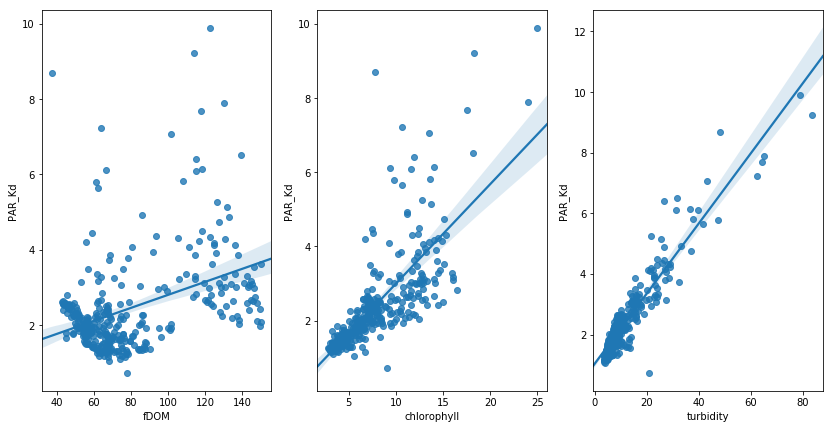

In [13]:
CS01=pd.concat([CS01_WQ, CS01_WV, CS01_WC, CS01_Kd],axis=1)

fig2=plt.figure(figsize=(14,7))
sns.regplot(x='fDOM', y='PAR_Kd', data=CS01, fit_reg=True, order=1, ax=fig2.add_subplot(1,3,1))
sns.regplot(x='chlorophyll', y='PAR_Kd', data=CS01, fit_reg=True, order=1, ax=fig2.add_subplot(1,3,2))
sns.regplot(x='turbidity', y='PAR_Kd', data=CS01, fit_reg=True, order=1, ax=fig2.add_subplot(1,3,3))

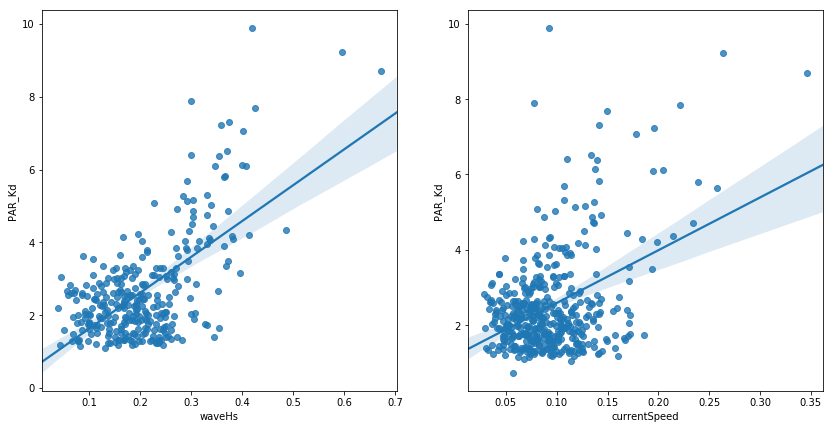

In [66]:
fig3=plt.figure(figsize=(14,7))

sns.regplot(x='waveHs', y='PAR_Kd', data=CS01, order=1, ax=fig3.add_subplot(1,2,1))
sns.regplot(x='currentSpeed', y='PAR_Kd', data=CS01, order=1, ax=fig3.add_subplot(1,2,2))

#### What if we could somehow remove the high-wind and storm wave effect from the data? 
#### How much might this attempt to isolate "typical" conditions impact results?

The 75th quantile for the significant wave height is 0.289935 m. So, 75% of the waves recorded at Station 01 are < 0.29 m. Though arbitrary, what if we assume (for now) that this 75% condition marks the upper boundary of "typical" wave energy conditions on Currituck Sound?

In [15]:
CS01=CS01[CS01['waveHs'] < 0.29 ]

,PAR_Kd,fDOM,chlorophyll,turbidity
PAR_Kd,1.000000,0.517252,0.815081,0.885150
fDOM,0.517252,1.000000,0.643632,0.467342
chlorophyll,0.815081,0.643632,1.000000,0.714684
turbidity,0.885150,0.467342,0.714684,1.000000


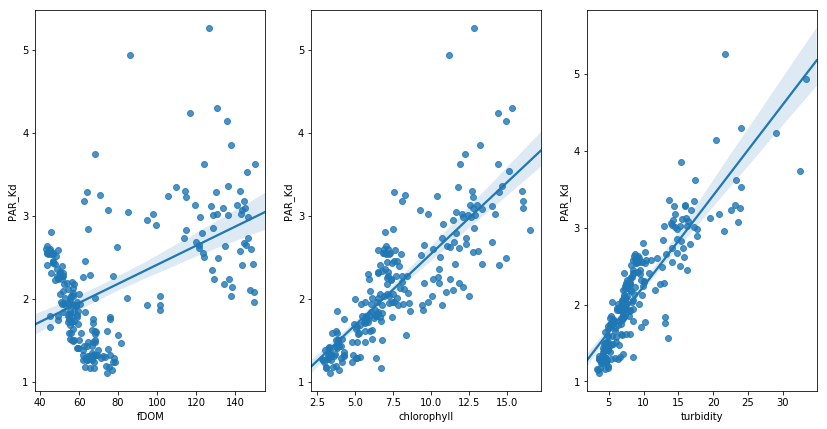

In [16]:
fig4=plt.figure(figsize=(14,7))
sns.regplot(x='fDOM', y='PAR_Kd', data=CS01, fit_reg=True, order=1, ax=fig4.add_subplot(1,3,1))
sns.regplot(x='chlorophyll', y='PAR_Kd', data=CS01, fit_reg=True, order=1, ax=fig4.add_subplot(1,3,2))
sns.regplot(x='turbidity', y='PAR_Kd', data=CS01, fit_reg=True, order=1, ax=fig4.add_subplot(1,3,3))

CS01[['PAR_Kd', 'fDOM','chlorophyll', 'turbidity']].corr()

,PAR_Kd,waveHs,currentSpeed
PAR_Kd,1.000000,0.150150,-0.113817
waveHs,0.150150,1.000000,0.544345
currentSpeed,-0.113817,0.544345,1.000000


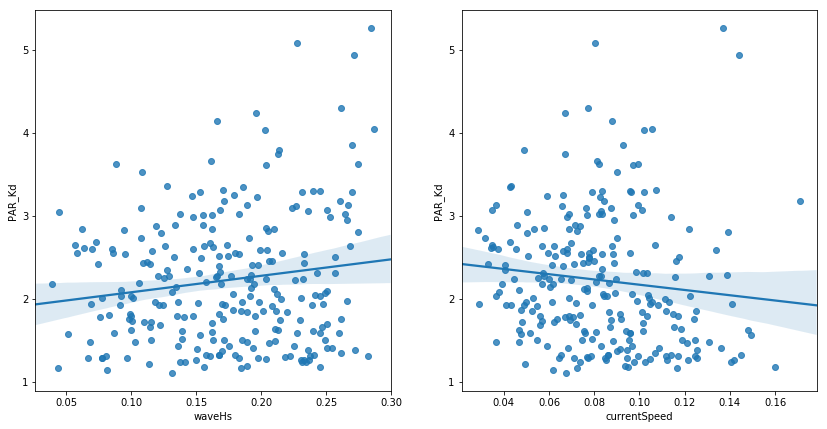

In [17]:
fig5=plt.figure(figsize=(14,7))

sns.regplot(x='waveHs', y='PAR_Kd', data=CS01, ax=fig5.add_subplot(1,2,1))
sns.regplot(x='currentSpeed', y='PAR_Kd', data=CS01, order=1, ax=fig5.add_subplot(1,2,2))

CS01[['PAR_Kd','waveHs','currentSpeed']].corr()

### Multiple Regression Experiment:

Rebuild the CS01 dataframe to include all records...

In [36]:
CS01=pd.concat([CS01_WQ, CS01_WV, CS01_WC, CS01_Kd],axis=1)

In [31]:
#Instantiate the regression model and setting parameters if any,
reg_model = LinearRegression(normalize=True)

R=CS01[['fDOM','chlorophyll','turbidity','waveHs','currentSpeed','PAR_Kd']].dropna()
X=R[['fDOM','chlorophyll','turbidity','waveHs','currentSpeed']]
y=R[['PAR_Kd']]

reg_model.fit(X, y)

P=reg_model.predict(X)

#outputs the coefficients
print('Intercept :', reg_model.intercept_[0], '\n')
print(pd.DataFrame({'features':X.columns,'coeficients':reg_model.coef_[0]}))

print("R^2: {:.2f}".format(reg_model.score(X, y)))

Intercept : 0.3160729623105154 

       features  coeficients
0          fDOM    -0.002293
1   chlorophyll     0.105449
2     turbidity     0.081921
3        waveHs     1.200531
4  currentSpeed     2.903745
R^2: 0.92


Text(0,0.5,'Observed Kd')

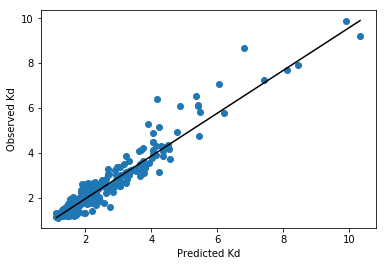

In [32]:
plt.scatter(P,R['PAR_Kd'])
plt.plot([P.min(),P.max()],[R['PAR_Kd'].min(), R['PAR_Kd'].max()], c='black')
plt.xlabel('Predicted Kd')
plt.ylabel('Observed Kd')

In [33]:
import statsmodels.api as sm

model11 = sm.OLS(y, sm.add_constant(X)).fit()
model11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 PAR_Kd   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                     582.2
Date:                Mon, 06 Aug 2018   Prob (F-statistic):          6.56e-138
Time:                        23:06:18   Log-Likelihood:                -135.24
No. Observations:                 263   AIC:                             282.5
Df Residuals:                     257   BIC:                             303.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.3161      0.116      2.723      0.007       0.087       0.545
fDOM            -0.0023      0.001     -1.875      0.062      -0.005       0.000
chlorophyll      0.1054      0.015      6.818      0.000       0.075       0.136
turbidity        0.0819      0.005     17.868      0.000       0.073       0.091
waveHs           1.2005      0.453      2.653      0.008       0.309       2.092
currentSpeed     2.9037      1.011      2.873      0.004       0.914       4.894
==============================================================================
Omnibus:                       76.623   Durbin-Watson:                   1.842
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              361.355
Skew:                           1.092   Prob(JB):                     3.41e-79
Kurtosis:                       8.311   Cond. No.                     3.71e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.71e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Regressing under "typical" conditions:

In [38]:
R=CS01[CS01['waveHs'] < 0.29 ][['fDOM','chlorophyll','turbidity','waveHs','currentSpeed',
                                'PAR_Kd']].dropna()
X=R[['fDOM','chlorophyll','turbidity','waveHs','currentSpeed']]
y=R[['PAR_Kd']]

model01 = sm.OLS(y, sm.add_constant(X)).fit()
model01.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 PAR_Kd   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     236.5
Date:                Mon, 06 Aug 2018   Prob (F-statistic):           2.72e-85
Time:                        23:12:47   Log-Likelihood:                -38.998
No. Observations:                 221   AIC:                             90.00
Df Residuals:                     215   BIC:                             110.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.7232      0.098      7.415      0.000       0.531       0.915
fDOM            -0.0031      0.001     -3.353      0.001      -0.005      -0.001
chlorophyll      0.1056      0.013      8.266      0.000       0.080       0.131
turbidity        0.0754      0.006     12.490      0.000       0.064       0.087
waveHs           0.9606      0.410      2.345      0.020       0.153       1.768
currentSpeed    -0.1695      0.899     -0.189      0.851      -1.941       1.602
==============================================================================
Omnibus:                       50.574   Durbin-Watson:                   1.295
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              254.510
Skew:                           0.758   Prob(JB):                     5.42e-56
Kurtosis:                       8.034   Cond. No.                     4.10e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.1e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

2.499483654735125

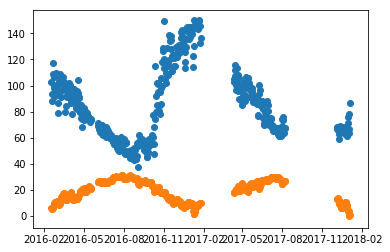

In [71]:
plt.scatter(CS01.index, CS01.fDOM)
plt.scatter(CS01.index, CS01.water_temp)
CS01.PAR_Kd.mean()